In [159]:
import numpy as np
from scipy import interpolate
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo

import scipy.constants as sc
from scipy import signal
from timeit import default_timer as timer
import csv

from astropy import units as u
from astropy.coordinates import Angle
from scipy.interpolate import RectBivariateSpline

import phase_corr_make_universe_3D as uni
import cross_spec_3D
import pspec_3D

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'STIXGeneral:italic'
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
plt.rcParams['mathtext.rm'] = 'STIXGeneral'


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
chunck_1 = np.arange(1420/(6.5+1),1420/(6+1),0.097) #central z = 6.25
chunck_2 = np.arange(1420/(7+1),1420/(6.5+1),0.097) #central z = 6.75
chunck_3 = np.arange(1420/(7.5+1),1420/(7+1),0.097) #central z = 7.25
chunck_4 = np.arange(1420/(8+1),1420/(7.5+1),0.097) #central z = 7.75

all_chuncks = np.array([chunck_1,chunck_2,chunck_3,chunck_4], dtype = object)

theta_box = Angle(2,u.degree)

z = [624,674,724,774]
z_label_t = [6.24,6.74,7.24,7.74]
z_label = [6.25,6.75,7.25,7.75]
colors  = ['royalblue' ,'darkseagreen','darkorange','darkmagenta']
nbins = 30
nbins_perp = 60

In [2]:
0.75/0.25

0.25/0.75

0.3333333333333333

# True Sky 

/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/pspec_3D.py:150: RuntimeWarning: invalid value encountered in true_divide
  ps = (a/c)/(self.volume3D)# [mk^2 Mpc^3]	# not suer about this 2D 3D vol thing
/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/pspec_3D.py:150: RuntimeWarning: invalid value encountered in true_divide
  ps = (a/c)/(self.volume3D)# [mk^2 Mpc^3]	# not suer about this 2D 3D vol thing
/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/pspec_3D.py:150: RuntimeWarning: invalid value encountered in true_divide
  ps = (a/c)/(self.volume3D)# [mk^2 Mpc^3]	# not suer about this 2D 3D vol thing
/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/pspec_3D.py:150: RuntimeWarning: invalid value encountered in true_divide
  ps = (a/c)/(self.volume3D)# [mk^2 Mpc^3]	# not suer about this 2D 3D vol thing


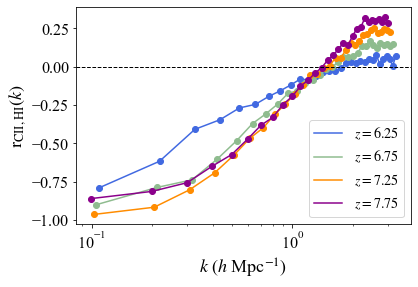

In [191]:
for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/SAZERAC/sky_sim_50/50_field_21cm_%s.txt"%z_label_t[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/SAZERAC/sky_sim_50/50_field_CII_%s.txt"%z_label_t[i]).reshape((50*50,len(all_chuncks[i])))
    
    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
#     cross_spec.compute_1d_from_2d()
    cross_spec.compute_1D_pspec()
    
    pspec_HI = pspec_3D.Power_Spectrum(HI,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_HI.compute_1D_pspec()
    
    pspec_CII = pspec_3D.Power_Spectrum(CII,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_CII.compute_1D_pspec()
    
    R = cross_spec.ps_1D/(np.sqrt(pspec_CII.ps_1D*pspec_HI.ps_1D))
    
    
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, label = "$z = %s$"%z_label[i], color = colors[i])
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, 'o',color = colors[i])

plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.xlabel(r'$k$ ($h$ Mpc$^{-1}$)', fontsize= 18)
plt.ylabel(r'r$_{\rm{CII,HI}}(k)$', fontsize= 18)
# plt.title('True Correlations', fontsize = 22 ,y = 1.01)
plt.legend(fontsize = 14)
# plt.xlim(0,1)


In [168]:
P_HI_true = np.zeros((4,30))
P_CII_true = np.zeros((4,30))
Px_true = np.zeros_like(P_auto_true)
kmodes = np.zeros(30)

for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/SAZERAC/sky_sim_50/50_field_21cm_%s.txt"%z_label_t[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/SAZERAC/sky_sim_50/50_field_CII_%s.txt"%z_label_t[i]).reshape((50*50,len(all_chuncks[i])))
    
    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    cross_spec.compute_1d_from_2d()
#     cross_spec.compute_1D_pspec()
    
    pspecHI = pspec_3D.Power_Spectrum(HI,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
#     pspecHI.compute_1D_pspec()
    pspecHI.compute_1d_from_2d()
    pspecCII = pspec_3D.Power_Spectrum(CII,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
#     pspecCII.compute_1D_pspec()
    pspecCII.compute_1d_from_2d()

    P_HI_true[i,:] = pspecHI.pspec_1D
    P_CII_true[i,:] = pspecCII.pspec_1D
    Px_true[i,:] = cross_spec.pspec_1D
    
    if i  == 0:
        kmodes = cross_spec.k_modes
    else:
        pass
    
    

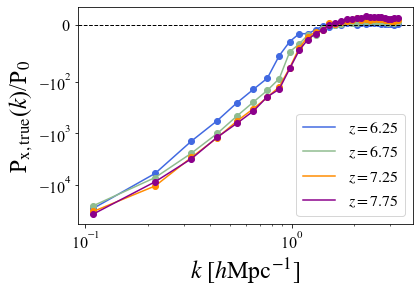

In [375]:
for i in range(4):

    plt.semilogx(kmodes/(cosmo.H0.value/100), Px_true[i,:], label = "$z = %s$"%z_label[i], color = colors[i])
    plt.semilogx(kmodes/(cosmo.H0.value/100), Px_true[i,:], 'o',color = colors[i])

plt.yscale('symlog', linthresh = 10**2)
# plt.locator_params(axis='y', nbins=7)
plt.ylabel(r'P$_\mathrm{x,true}$($k$)/P$_0$', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.legend(fontsize = 16)

# \mathrm{K (Jy/sr)} \mathrm{Mpc}^{-3})})

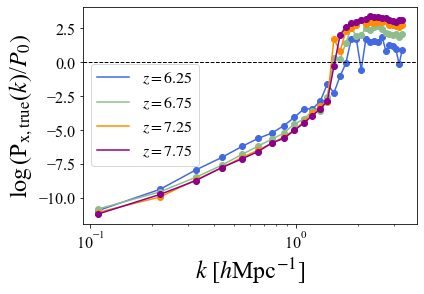

In [169]:
for i in range(4):

    plt.semilogx(kmodes/(cosmo.H0.value/100), Px_true[i,:], label = "$z = %s$"%z_label[i], color = colors[i])
    plt.semilogx(kmodes/(cosmo.H0.value/100), np.arcsinh(Px_true[i,:]), 'o',color = colors[i])
plt.yscale('symlog')
plt.locator_params(axis='y', nbins=7)
plt.ylabel(r'$\log$(P$_\mathrm{x,true}$($k$)/$P_0)$', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.legend(fontsize = 16)

# \mathrm{K (Jy/sr)} \mathrm{Mpc}^{-3})})

fig3 = plt.figure(figsize = (20,4),constrained_layout=False)
gs = fig3.add_gridspec(1,2 , hspace = 0.15,wspace=1)


f3_ax2 = fig3.add_subplot(gs[0, 1])
line_21 = f3_ax2.semilogx(kmodes/(cosmo.H0.value/100),P_HI_true[1,:],marker = 'o', color = 'royalblue' ,label = '21 cm')
f3_ax2.semilogx(kmodes/(cosmo.H0.value/100),P_HI_true[1,:], color = 'royalblue', linewidth = 5,label = '21 cm')
formatter = ticker.ScalarFormatter(useMathText=True) 
f3_ax2.yaxis.set_major_formatter(formatter)


f3_ax3 = f3_ax2.twinx()

line_CII = f3_ax3.semilogx(kmodes/(cosmo.H0.value/100),P_CII_true[1,:], marker = '.',color = 'darkorange', label = '[CII]')
f3_ax3.semilogx(kmodes/(cosmo.H0.value/100),P_CII_true[1,:], color = 'darkorange', label = '[CII]')
f3_ax3.set_ylabel(r'P$_{[CII]}$(k) [(Jy/sr)$^2$ Mpc$^{-3}$]',fontsize = 18)
f3_ax2.set_ylabel(r'P$_{21}$(k) [K$^2$ Mpc$^{-3}$]',fontsize = 18)



f3_ax2.set_xlabel('k [$\mathcal{h}$Mpc$^{-1}$]', fontsize = 18)

plt.style.use('tableau-colorblind10')


# Instrument Alone

In [246]:
cross_window = np.zeros((4,30))
for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_alone/obs_hera_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_alone/ccat_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    
    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,50)
    cross_spec.compute_1D_pspec()
    
    cross_window[i,:] = cross_spec.ps_1D
    
   

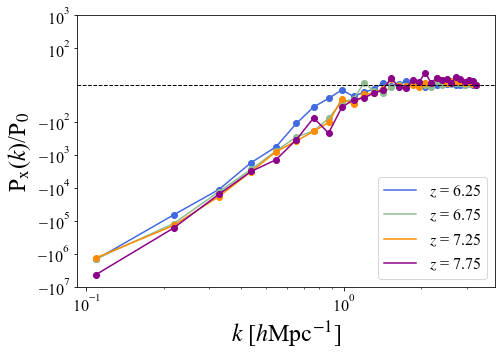

In [377]:
import matplotlib.ticker as mticker


fig, (ax) = plt.subplots(1,1, figsize=(7.5,5), gridspec_kw={'wspace':.2})


for i in range(4):
    
    ax.semilogx(kmodes/(cosmo.H0.value/100), cross_window[i,:], 'o',color = colors[i])
    ax.semilogx(kmodes/(cosmo.H0.value/100),cross_window[i,:],label = "$z$ = %s"%z_label[i],color = colors[i])
    
ax.set_yscale('symlog',linthresh = 10**2)

sym = mticker.SymmetricalLogLocator(linthresh = 10**2, base=10)
sym.set_params(numticks=6)
ax.yaxis.set_major_locator(sym)


ax.set_ylabel(r'P$_\mathrm{x}$($k$)/P$_0$', fontsize = 24)
ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
ax.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
ax.legend(fontsize = 16)
ax.set_ylim(-10**7,10**3)

yticks = ax.yaxis.get_major_ticks()
yticks[-3].set_visible(False)


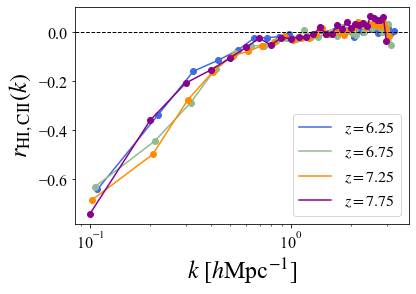

In [226]:
P_HI_window = np.zeros((4,30))
P_CII_window = np.zeros((4,30))

for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_alone/obs_hera_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_alone/ccat_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    
    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
#     cross_spec.compute_1d_from_2d()
    cross_spec.compute_1D_pspec()
    
    pspec_HI = pspec_3D.Power_Spectrum(HI,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_HI.compute_1D_pspec()
    
    pspec_CII = pspec_3D.Power_Spectrum(CII,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_CII.compute_1D_pspec()
    
    P_HI_window[i,:] = pspecHI.pspec_1D
    P_CII_window[i,:] = pspecCII.pspec_1D
    
    R = cross_spec.ps_1D/np.sqrt(pspec_HI.ps_1D*pspec_CII.ps_1D)
    
    
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, label = "$z = %s$"%z_label[i], color = colors[i])
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, 'o',color = colors[i])

plt.locator_params(axis='y', nbins=7)
plt.ylabel(r'$r_\mathrm{HI,CII}(k)$', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.legend(fontsize = 16)



# Instrument + noise

In [400]:
cross_n = np.zeros_like(cross_window)

for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_noise/obs_hera_noise_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_noise/ccat_noise_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))

    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,50)
    cross_spec.compute_1D_pspec()
    
    cross_n[i,:] = cross_spec.ps_1D
    
#     plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec.ps_1D, 'o',color = colors[i])
#     plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec.ps_1D,label = "$z$ = %s"%z_label[i],color = colors[i])

# # plt.locator_params(axis='y', nbins=7)
# plt.yscale('symlog')
# plt.ylabel(r'$\log$(P$_\mathrm{x}$($k$)/$P_0)$', fontsize = 24)
# plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
# plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
# plt.legend(fontsize = 16)





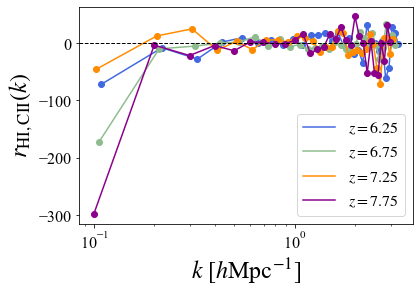

In [239]:
for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_noise/obs_hera_noise_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_noise/ccat_noise_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    
    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
#     cross_spec.compute_1d_from_2d()
    cross_spec.compute_1D_pspec()
    
    pspec_HI = pspec_3D.Power_Spectrum(HI,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_HI.compute_1D_pspec()
    
    pspec_CII = pspec_3D.Power_Spectrum(CII,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_CII.compute_1D_pspec()
    
    R = cross_spec.ps_1D/np.sqrt(P_HI_true[i,:]*P_CII_true[i,:])
    
    
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, label = "$z = %s$"%z_label[i], color = colors[i])
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, 'o',color = colors[i])

plt.locator_params(axis='y', nbins=7)
plt.ylabel(r'$r_\mathrm{HI,CII}(k)$', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.legend(fontsize = 16)



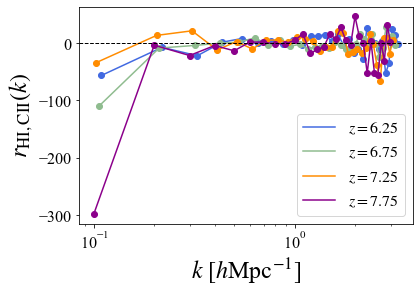

In [225]:
for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_noise/obs_hera_noise_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_noise/ccat_noise_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    
    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
#     cross_spec.compute_1d_from_2d()
    cross_spec.compute_1D_pspec()
    
    pspec_HI = pspec_3D.Power_Spectrum(HI,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_HI.compute_1D_pspec()
    
    pspec_CII = pspec_3D.Power_Spectrum(CII,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_CII.compute_1D_pspec()
    
    R = cross_spec.ps_1D/np.sqrt(P_HI_window[i,:]*P_CII_window[i,:])
    
    
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, label = "$z = %s$"%z_label[i], color = colors[i])
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, 'o',color = colors[i])

plt.locator_params(axis='y', nbins=7)
plt.ylabel(r'$r_\mathrm{HI,CII}(k)$', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.legend(fontsize = 16)



# Instrument + noise + diffuse foreground

In [401]:
cross_n_fg = np.zeros_like(cross_window)

for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_fg/obs_sky_Hnoise_fg_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_fg/ccat_noise_fg_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))

    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,50)
    cross_spec.compute_1D_pspec()
    
    cross_n_fg[i,:] = cross_spec.ps_1D
    
#     plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec.ps_1D, 'o',color = colors[i])
#     plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec.ps_1D,label = "$z$ = %s"%z_label[i],color = colors[i])

# plt.locator_params(axis='y', nbins=7)
# plt.ylabel(r'$\log$(P$_\mathrm{x}$($k$)/$P_0)$', fontsize = 24)
# plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
# plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
# plt.legend(fontsize = 16)


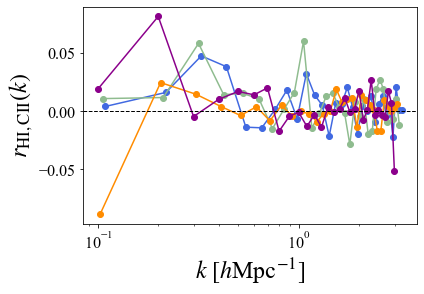

In [224]:

for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_fg/obs_sky_Hnoise_fg_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_fg/ccat_noise_fg_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
 
    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
#     cross_spec.compute_1d_from_2d()
    cross_spec.compute_1D_pspec()
    
    pspec_HI = pspec_3D.Power_Spectrum(HI,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_HI.compute_1D_pspec()
    
    pspec_CII = pspec_3D.Power_Spectrum(CII,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_CII.compute_1D_pspec()
    
    
    R = cross_spec.ps_1D/np.sqrt(pspec_HI.ps_1D*pspec_CII.ps_1D)
    
    
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, label = "$z = %s$"%z_label[i], color = colors[i])
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, 'o',color = colors[i])

plt.locator_params(axis='y', nbins=7)
plt.ylabel(r'$r_\mathrm{HI,CII}(k)$', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
# plt.legend(fontsize = 16)


In [93]:
HI_fg_625 = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_fg/obs_sky_Hnoise_fg_%s.txt"%724).reshape((50*50,len(all_chuncks[2])))
# CII_fg_625 = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_fg/ccat_noise_fg_%s.txt"%624).reshape((50*50,len(all_chuncks[i])))

HI_fg_625 = HI_fg_625.reshape((50,50,len(all_chuncks[2])))
#     CII = CII.reshape((50,50,len(all_chuncks[i])))

In [94]:
pspec = pspec_3D.Power_Spectrum(HI_fg_625, theta_box.radian, theta_box.radian, all_chuncks[2],1420,30)
pspec.compute_2D_pspec()



/var/folders/rx/h899l7s51ds34rqj_3lmczzh0000gn/T/ipykernel_5220/311098125.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(pspec.k_perp_bin,pspec.k_par,pspec.pspec_2D, edgecolors='w', linewidth=0.5)


Text(0.5, 0, 'k$_{\\perp}[Mpc^{-1}]$')

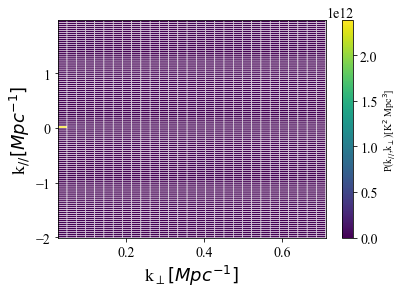

In [95]:
im = plt.pcolor(pspec.k_perp_bin,pspec.k_par,pspec.pspec_2D, edgecolors='w', linewidth=0.5)
plt.colorbar(label = 'P(k$_{//}$,k$_{\perp}$)[K$^2$ Mpc$^3$]') #worried about the scale, i think here you only need to divide by the 2d vol you're averaging over not the entire 3D vol. 
plt.ylabel('k$_{//}[Mpc^{-1}]$', fontsize = 18)
plt.xlabel('k$_{\perp}[Mpc^{-1}]$', fontsize = 18)

# Instrument + noise + diffuse foreground + bright source

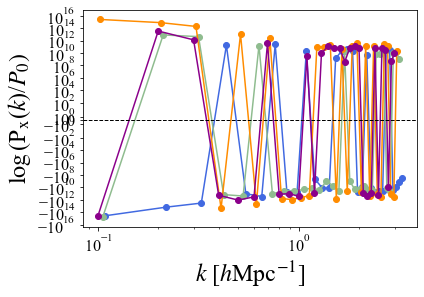

In [402]:
cross_n_fg_ps = np.zeros_like(cross_window)

for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_ps/obs_Hnoise_fg_ps_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_fg/ccat_noise_fg_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))

    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,50)
    cross_spec.compute_1D_pspec()
    
    cross_n_fg_ps[i,:] = cross_spec.ps_1D
    
#     plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec.ps_1D, 'o',color = colors[i])
#     plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec.ps_1D,label = "$z$ = %s"%z_label[i],color = colors[i])

# # plt.locator_params(axis='y', nbins=7)
# plt.yscale('symlog')
# plt.ylabel(r'$\log$(P$_\mathrm{x}$($k$)/$P_0)$', fontsize = 24)
# plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
# plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
# # plt.legend(fontsize = 16)


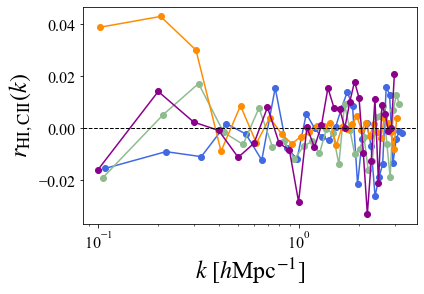

In [223]:

for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Hera_ps/obs_Hnoise_fg_ps_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_fg/ccat_noise_fg_%s.txt"%z[i]).reshape((50*50,len(all_chuncks[i])))
  
    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
#     cross_spec.compute_1d_from_2d()
    cross_spec.compute_1D_pspec()
    
    pspec_HI = pspec_3D.Power_Spectrum(HI,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_HI.compute_1D_pspec()
    
    pspec_CII = pspec_3D.Power_Spectrum(CII,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_CII.compute_1D_pspec()
    
    
    R = cross_spec.ps_1D/np.sqrt(pspec_HI.ps_1D*pspec_CII.ps_1D)
    
    
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, label = "$z = %s$"%z_label[i], color = colors[i])
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, 'o',color = colors[i])

plt.locator_params(axis='y', nbins=7)
plt.ylabel(r'$r_\mathrm{HI,CII}(k)$', fontsize = 24)
plt.xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
# plt.legend(fontsize = 16)


# Plotting

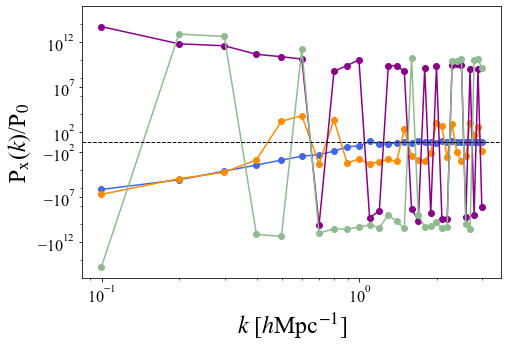

In [417]:
fig, (ax) = plt.subplots(1,1, figsize=(7.5,5), gridspec_kw={'wspace':.2})


ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_window[1,:], 'o',color = 'royalblue')
ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100),cross_window[1,:],label = r"P$_\mathrm{est,wrong}$",color = 'royalblue')

ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_n[1,:] , 'o',color = 'darkorange')
ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_n[1,:] ,label = r"P$_\mathrm{wrong}$",color = 'darkorange')

ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_n_fg[1,:], 'o',color = 'darkmagenta')
ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100),cross_n_fg[1,:] ,label = r"P$_\mathrm{ps, wrong}$",color = 'darkmagenta')

ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_n_fg_ps[1,:], 'o',color = 'darkseagreen')
ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100),cross_n_fg_ps[1,:] ,label = r"P$_\mathrm{ps, wrong}$",color = 'darkseagreen')

ax.set_yscale('symlog',linthresh = 10**2)

sym = mticker.SymmetricalLogLocator(linthresh = 10**2, base=10)
sym.set_params(numticks=6)
ax.yaxis.set_major_locator(sym)


ax.set_ylabel(r'P$_\mathrm{x}$($k$)/P$_0$', fontsize = 24)
ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
ax.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
# ax.legend(fontsize = 16)
ax.set_ylim(-10**16,10**16)

yticks = ax.yaxis.get_major_ticks()
yticks[-4].set_visible(False)




# Beam Mismodelling

In [231]:


HI_w = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Beam_stuff/obs_hera_bw_674.txt").reshape((50*50,len(all_chuncks[1])))
CII_w = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/ccat_alone/ccat_674.txt").reshape((50*50,len(all_chuncks[1])))

HI_w = HI_w.reshape(50,50,len(all_chuncks[1]))
CII_w = CII_w.reshape(50,50,len(all_chuncks[1]))

cross_spec_w = cross_spec_3D.Power_Spectrum(HI_w,CII_w, theta_box.radian, theta_box.radian,all_chuncks[1],1420,nbins,50)
cross_spec_w.compute_1D_pspec()
#_____________________________

HI_b = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Beam_stuff/obs_hera_beam_674.txt").reshape((50*50,len(all_chuncks[1])))

HI_b = HI_b.reshape(50,50,len(all_chuncks[1]))

cross_spec_b = cross_spec_3D.Power_Spectrum(HI_b,CII_w, theta_box.radian, theta_box.radian,all_chuncks[1],1420,nbins,50)
cross_spec_b.compute_1D_pspec() 
#_____________________________

HI_p = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/SAZERAC_results/Beam_stuff/obs_hera_beamps_noise_674.txt").reshape((50*50,len(all_chuncks[1])))

HI_p = HI_p.reshape(50,50,len(all_chuncks[1]))

cross_spec_p = cross_spec_3D.Power_Spectrum(HI_p,CII_w, theta_box.radian, theta_box.radian,all_chuncks[1],1420,nbins,50)
cross_spec_p.compute_1D_pspec()



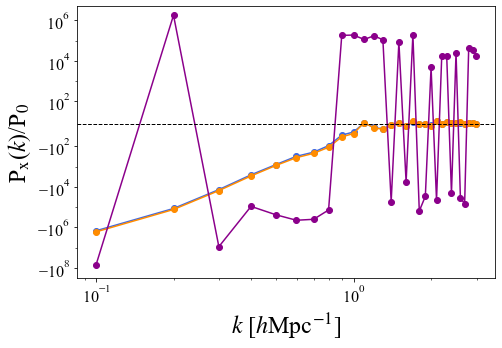

In [413]:
fig, (ax) = plt.subplots(1,1, figsize=(7.5,5), gridspec_kw={'wspace':.2})


ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec_w.ps_1D, 'o',color = 'royalblue')
ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec_w.ps_1D,label = r"P$_\mathrm{est,wrong}$",color = 'royalblue')

ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec_b.ps_1D, 'o',color = 'darkorange')
ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec_b.ps_1D,label = r"P$_\mathrm{wrong}$",color = 'darkorange')

ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec_p.ps_1D, 'o',color = 'darkmagenta')
ax.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), cross_spec_p.ps_1D,label = r"P$_\mathrm{ps, wrong}$",color = 'darkmagenta')

ax.set_yscale('symlog',linthresh = 10**2)

sym = mticker.SymmetricalLogLocator(linthresh = 10**2, base=10)
sym.set_params(numticks=6)
ax.yaxis.set_major_locator(sym)


ax.set_ylabel(r'P$_\mathrm{x}$($k$)/P$_0$', fontsize = 24)
ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
ax.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
# ax.legend(fontsize = 16)
ax.set_ylim(-10**8.5,10**6.7)

yticks = ax.yaxis.get_major_ticks()
yticks[-4].set_visible(False)


